# Classifying Disaster Response Messages

Get the dataset [here](https://www.figure-eight.com/dataset/combined-disaster-response-data/).

In [2]:
%load_ext autoreload
%autoreload 2

# append python sources to path
import sys
sys.path.append('../src/')

In [3]:
# imports
import itertools
from pathlib import Path

# data wrangling
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# modelling and evaluation
from scipy.stats import randint, uniform
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.externals import joblib
from xgboost import XGBClassifier

from load_data import load_dataset, read, make_training_dataset
from build_features import ngram_features, select_best_features
from explore_data import get_class_ratio
from train_bow_models import naive_bayes, svm, xgboost, mlp

In [4]:
# default matplotlib settings
plt.rcdefaults()

In [4]:
# constants
TRAIN = Path('../data/disaster_response_messages_training.csv')
VAL = Path('../data/disaster_response_messages_validation.csv')
TEST = Path('../data/disaster_response_messages_test.csv')

## Exploratory Data Analysis

Explore the training data.

In [5]:
train = pd.concat([read(TRAIN), read(VAL)], axis=0)
print('Rows: {}, columns: {}'.format(train.shape[0], train.shape[1]))

Rows: 17720, columns: 37


#### Class imbalance

In [6]:
class_ratio = pd.DataFrame.from_dict(get_class_ratio(train, train.columns[6:]), orient='index')
class_ratio.columns = ['ratio']

In [7]:
# most imbalanced
class_ratio.sort_values('ratio', ascending=False).head()

,ratio
shops,155.81
tools,113.32
hospitals,65.87
fire,64.39
missing_people,61.61


In [8]:
# least imbalanced
class_ratio.sort_values('ratio', ascending=True).head()

,ratio
weather_related,1.70
direct_report,2.97
other_aid,4.49
food,5.80
earthquake,6.95


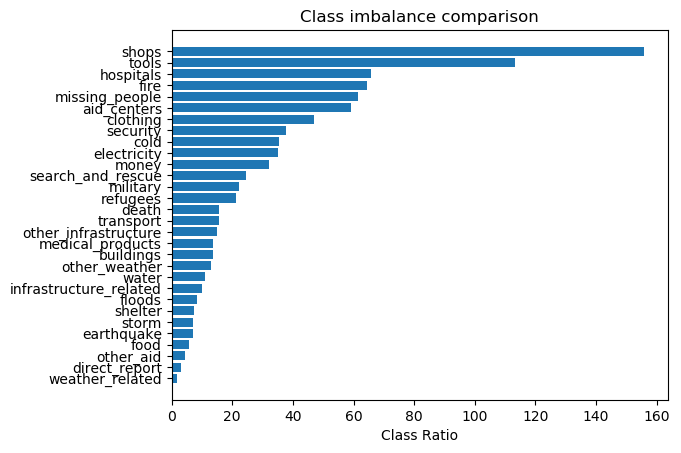

In [9]:
# plot class ratio
class_ratio = class_ratio.sort_values('ratio', ascending=True)
objects = class_ratio.index.tolist()
y_pos = np.arange(len(objects))
ratio = class_ratio['ratio'].tolist()

plt.barh(y_pos, ratio, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Class Ratio')
plt.title('Class imbalance comparison')
 
plt.show()

#### Sentence length distribution

After removing stopwords and doing `min_df = 2`.

In [10]:
vec = CountVectorizer(analyzer='word', stop_words='english', min_df=2)
x_counts = vec.fit_transform(train['message'].values)

print('Vocab size: {}'.format(len(vec.vocabulary_)))

Vocab size: 13064


In [11]:
# bin into intervals
train['sen_length'] = np.apply_along_axis(np.sum, 1, x_counts.toarray())
bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, 1000)])
train['sen_length_category'] = pd.cut(train['sen_length'], bins)

# prepare sentence length for bar plot
sen_length_dist = train['sen_length_category'].value_counts().reset_index()
sen_length_dist.columns = ['range', 'frequency']
sen_length_dist = sen_length_dist.sort_values('range')

In [12]:
print('Mean message length: {}, median: {}'.format(round(train['sen_length'].mean(), 2),
                                                   train['sen_length'].median()))

Mean message length: 13.49, median: 11.0


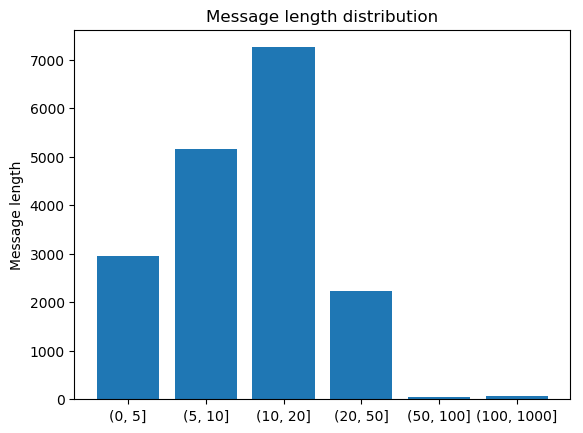

In [13]:
# plot class ratio
objects = sen_length_dist['range'].tolist()
y_pos = np.arange(len(objects))
freq = sen_length_dist['frequency'].tolist()

plt.bar(y_pos, freq, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Message length')
plt.title('Message length distribution')
 
plt.show()

## Text Classifier

In [14]:
# load data
COLUMN = 'weather_related'
X_train, y_train = make_training_dataset(TRAIN, VAL, COLUMN)
X_test, y_test = load_dataset(TEST, COLUMN)

# vectorize data, learn on training, apply on test
X_train, X_test = ngram_features(X_train, X_test)

# select top 15000 features on training dataset, apply the same to test dataset
X_train, X_test = select_best_features(X_train, y_train, X_test)

In [15]:
# for convenience
train_data = X_train, y_train
test_data = X_test, y_test

### When using feature selection

In [16]:
%time naive_bayes(train_data, test_data, Path('../models/nb.top.features'))

precision = 0.56, recall = 0.66, f-score = 0.61
CPU times: user 433 ms, sys: 398 ms, total: 831 ms
Wall time: 830 ms


In [17]:
%time svm(train_data, test_data, Path('../models/svm.top.features'))

Best params:  {'C': 1.0}
precision = 0.78, recall = 0.88, f-score = 0.82
CPU times: user 232 ms, sys: 90.2 ms, total: 322 ms
Wall time: 3.22 s


In [18]:
%time xgboost(train_data, test_data, Path('../models/xgb.top.features'))

Best params:  {'learning_rate': 0.3752080885943653, 'max_depth': 6}
precision = 0.76, recall = 0.92, f-score = 0.83
CPU times: user 4.91 s, sys: 60.7 ms, total: 4.97 s
Wall time: 3min 33s


In [19]:
%time mlp(train_data, test_data, Path('../models/mlp.top.features'))

Best params:  {'hidden_layer_sizes': (4, 50), 'learning_rate': 'adaptive'}
precision = 0.75, recall = 0.81, f-score = 0.78
CPU times: user 3.71 s, sys: 10.1 ms, total: 3.72 s
Wall time: 1min 1s
